In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import mcf4pingpong as mp
from mcf4pingpong import draw_util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

In [104]:
def rk4_step(f,y0,t_prev, t):
    h = t - t_prev
    k1 = h * f(t_prev, y0)
    k2 = h * f(t_prev + 0.5*h, y0 + 0.5*k1)
    k3 = h * f(t_prev + 0.5*h, y0 + 0.5*k2)
    k4 = h * f(t, y0 + k3)
    return y0 + (k1 + 2*k2 + 2*k3 + k4) / 6
    
def aero_dynamics(t,y):
    '''
    y = [p, dp,w]
    '''
    p = y[:3]
    v = y[3:6]
    w = y[6:]
    
    g = np.array([0,0,-9.81])
    m = 0.0027 # kg
    r = 0.020 # m
    rho_air = 1.29
    Inert = 2 * m * r**2 /3

    C_d = 0.5
    C_m = 0.2 # guess
    
    
    dy_dt = np.zeros(9)
    dy_dt[:3] = v
    acc_gravity = g
    acc_aero = -0.125 * C_d * rho_air * np.pi * (2*r)**2 * np.linalg.norm(v)*v
    acc_magnus = 0.125 * C_m * rho_air * np.pi * (2*r)**3 * np.cross(w,v)

    dy_dt[3:6] = acc_gravity + acc_aero + acc_magnus

    return dy_dt
    
def bounce_dynamics(y):
    '''
    change the value directly
    
    y = [p, dp,w]
    
    '''
    v_i = y[3:6]
    w_i = y[6:]
    v_ix, v_iy, v_iz = v_i
    w_ix, w_iy, w_iz = w_i

    r = 0.020 #m
    mu = 0.2 # guess
    k_v = 0.7 # guess

    
    v_ez = -k_v * v_iz # restitution

    v_bi = np.array([v_ix - r* w_iy, v_iy + r*w_ix, 0])
    v_r_hat = v_bi / np.linalg.norm(v_bi)

    alpha = mu * (1 + k_v) * np.abs(v_iz) / np.sqrt((v_ix - w_iy * r)**2 + (v_iy + w_ix * r)**2)
    alpha = 0.4 if alpha > 0.4 else alpha
    
    A = np.diag([1-alpha, 1-alpha, -k_v])
    B = np.zeros((3,3)); B[0,1] = alpha * r; B[1,0] = -alpha * r
    C =  np.zeros((3,3)); B[0,1] = -1.5*alpha/r; B[1,0] = 1.5*alpha/r
    D = np.diag([1 - 1.5*alpha, 1 - 1.5 * alpha, 1.0])

    v_e = A @ v_i + B @ w_i
    w_e =  C @ v_i + D @ w_i 

    y_e = np.zeros(9)
    y_e[:3] = y[:3]
    y_e[3:6] = v_e
    y_e[6:] = w_e

    return y_e
    

def int_ode(y0,tspan, z0 = 0.0):
    yN = np.zeros((len(tspan), 9))
    yN[0,:] = y0

    for i in range(1,len(tspan)):
        y = yN[i-1]
        if yN[i-1,2] < z0 and yN[i-1,5] < 0.0:
            y = bounce_dynamics(y)
        yN[i] = rk4_step(aero_dynamics, y, tspan[i-1], tspan[i])

    return yN


def trajectory(p0,v0,w0):
    # p0 = np.array([0, 0, 0.5])
    # v0 = np.array([1,0,0])
    # w0 = np.array([0.01,0,0])
    y0 = np.array([p0,v0,w0]).flatten()
    tspan = np.linspace(0,3,1000)
    yN = int_ode(y0,tspan, z0=0.0)
    return  yN[:,0],  yN[:,1],  yN[:,2]

In [96]:
p0 = np.array([0, 0, 0.5])
v0 = np.array([1,0,0])
w0 = np.array([0.01,0,0])
y0 = np.array([p0,v0,w0]).flatten()
tspan = np.linspace(0,3,1000)
yN = int_ode(y0,tspan, z0=0.0)


Text(0.5, 0, 'z')

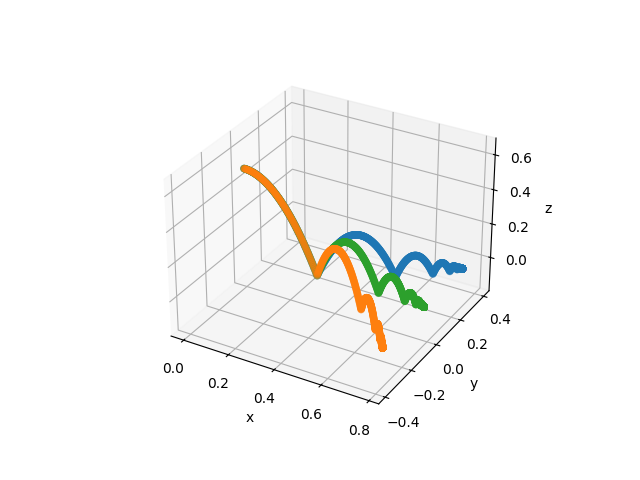

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

px, py, pz = trajectory([0, 0, 0.5],[1, 0, 0],[0.01,0,1])
ax.scatter(px,py,pz)
px, py, pz = trajectory([0, 0, 0.5],[1, 0, 0],[-0.01,0,-1])
ax.scatter(px,py,pz)
px, py, pz = trajectory([0, 0, 0.5],[1, 0, 0],[0,0,0])
ax.scatter(px,py,pz)

draw_util.set_axes_equal(ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
